In [1]:
import reservoir as rdl
import numpy as np
import scipy.stats
import sklearn.metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")

## Proportion of synergistic combinations in Almanac

In [2]:
blocks = rdl.get_specific_drug_combo_blocks(
    # data_set='DrugComb',
    # version=1.5,
    study_name="ALMANAC",
)["block_id"]

combo_data = rdl.get_drug_combo_data_combos(
            block_ids=blocks#, data_set='DrugComb', version=1.5
        )

In [3]:
prop_above_30 = (combo_data['synergy_bliss_max'] > 30).sum() / len(combo_data['synergy_bliss_max'])

In [4]:
prop_above_30

0.05326809665866546

# Estimate the level of noise

Measure the standard deviation of synergy scores across replicates in Almanac

In [5]:
all_CL = list(combo_data['cell_line_name'].unique())

all_reps_stds = []

for cell_line in all_CL:
    combo_data_CL = combo_data[combo_data['cell_line_name'] == cell_line]
    standard_deviations_bliss = combo_data_CL[['drug_row_recover_id', 
                                               'drug_col_recover_id', 
                                               'synergy_bliss_max']].groupby(['drug_row_recover_id', 
                                                                          'drug_col_recover_id']).std()
    all_reps_stds.extend(list(standard_deviations_bliss.value_counts().index))
    
all_reps_stds = [a[0] for a in all_reps_stds]

In [6]:
real_bliss_sigma = np.mean(all_reps_stds)  # Level of noise
real_bliss_sigma_std = np.std(all_reps_stds)

In [7]:
all_bliss = np.array(combo_data['synergy_bliss_max'])

## Simulate a noisy acquisition process

with different levels of (simulated) noise

In [8]:
all_spear_corr = []
all_r2 = []
for bliss_sigma in np.arange(0, 10, 0.1):
    for i in range(3):
        observed_bliss = all_bliss + bliss_sigma*np.random.randn(all_bliss.shape[0])
        spear_corr = scipy.stats.spearmanr(all_bliss, observed_bliss).correlation
        r2 = sklearn.metrics.r2_score(all_bliss, observed_bliss)
        
        all_spear_corr.append([bliss_sigma, spear_corr])
        all_r2.append([bliss_sigma, r2])

In [9]:
all_spear_corr = pd.DataFrame(all_spear_corr)
all_spear_corr.columns = ['noise level', 'Spearman correlation']

all_r2 = pd.DataFrame(all_r2)
all_r2.columns = ['noise level', 'R-squared']

In [28]:
tolerance = 1e-3

# Filter the DataFrame using the tolerance to find the row where 'noise level' approximately equals real_bliss_sigma
filtered_df = all_r2[np.isclose(all_r2['noise level'], real_bliss_sigma, atol=tolerance)]

# Check if the filtered DataFrame is not empty
if not filtered_df.empty:
    # Extract the Spearman correlation value
    spearman_corr_value = filtered_df['Spearman correlation'].values[0]
    print("The Spearman correlation value is:", spearman_corr_value)
else:
    print("No matching 'noise level' found.")

No matching 'noise level' found.


In [10]:
real_bliss_sigma

8.244035950402411

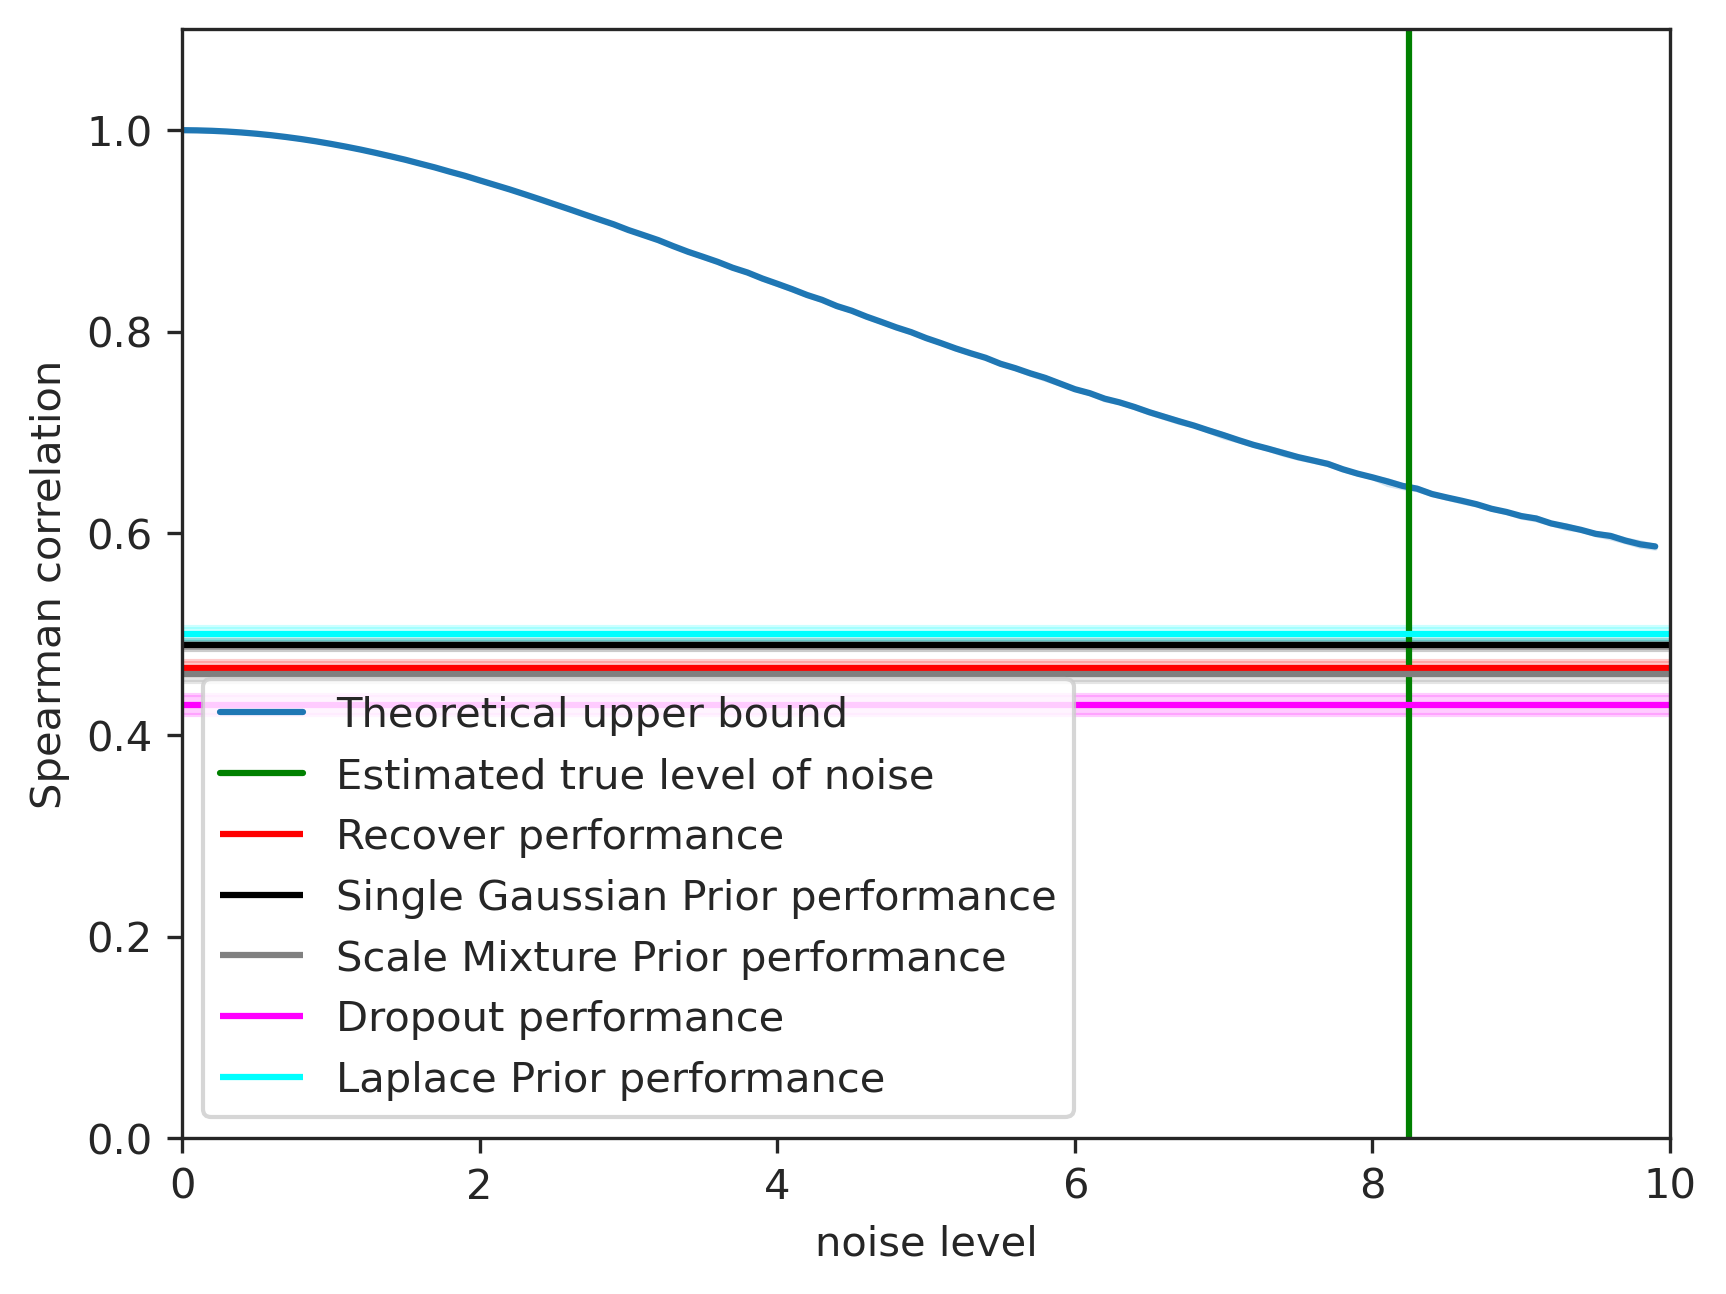

In [29]:
plt.figure(dpi=300)
sns.lineplot(data=all_spear_corr, x='noise level', y='Spearman correlation', label="Theoretical upper bound")

plt.axvline(x=real_bliss_sigma, color='green', label="Estimated true level of noise")

# Best Recover perf for spearman corr. 0.466 ± 0.007
plt.hlines(y=0.466, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='red', label="Recover performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.466-0.007, 0.466-0.007], y2=[0.466+0.007, 0.466+0.007], alpha=0.2, color='red')

# Best Single Gaussian for spearman corr. 0.489 ± 0.005
plt.hlines(y=0.489, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='black', label="Single Gaussian Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.489-0.005, 0.489-0.005], y2=[0.489+0.005, 0.489+0.005], alpha=0.2, color='black')

# Best Mixture Gaussian for spearman corr. 0.46 ± 0.007
plt.hlines(y=0.46, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='grey', label="Scale Mixture Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.46-0.007, 0.46-0.007], y2=[0.46+0.007, 0.46+0.007], alpha=0.2, color='grey')

# Best Dropout for spearman corr. 0.43 ± 0.01
plt.hlines(y=0.43, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='magenta', label="Dropout performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.43-0.01, 0.43-0.01], y2=[0.43+0.01, 0.43+0.01], alpha=0.2, color='magenta')

# Best Laplace for spearman corr. 0.50 ± 0.007
plt.hlines(y=0.50, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='cyan', label="Laplace Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.50-0.007, 0.50-0.007], y2=[0.50+0.007, 0.50+0.007], alpha=0.2, color='cyan')

plt.ylim(0, 1.1)
plt.xlim(0, 10)
plt.legend()
plt.show()

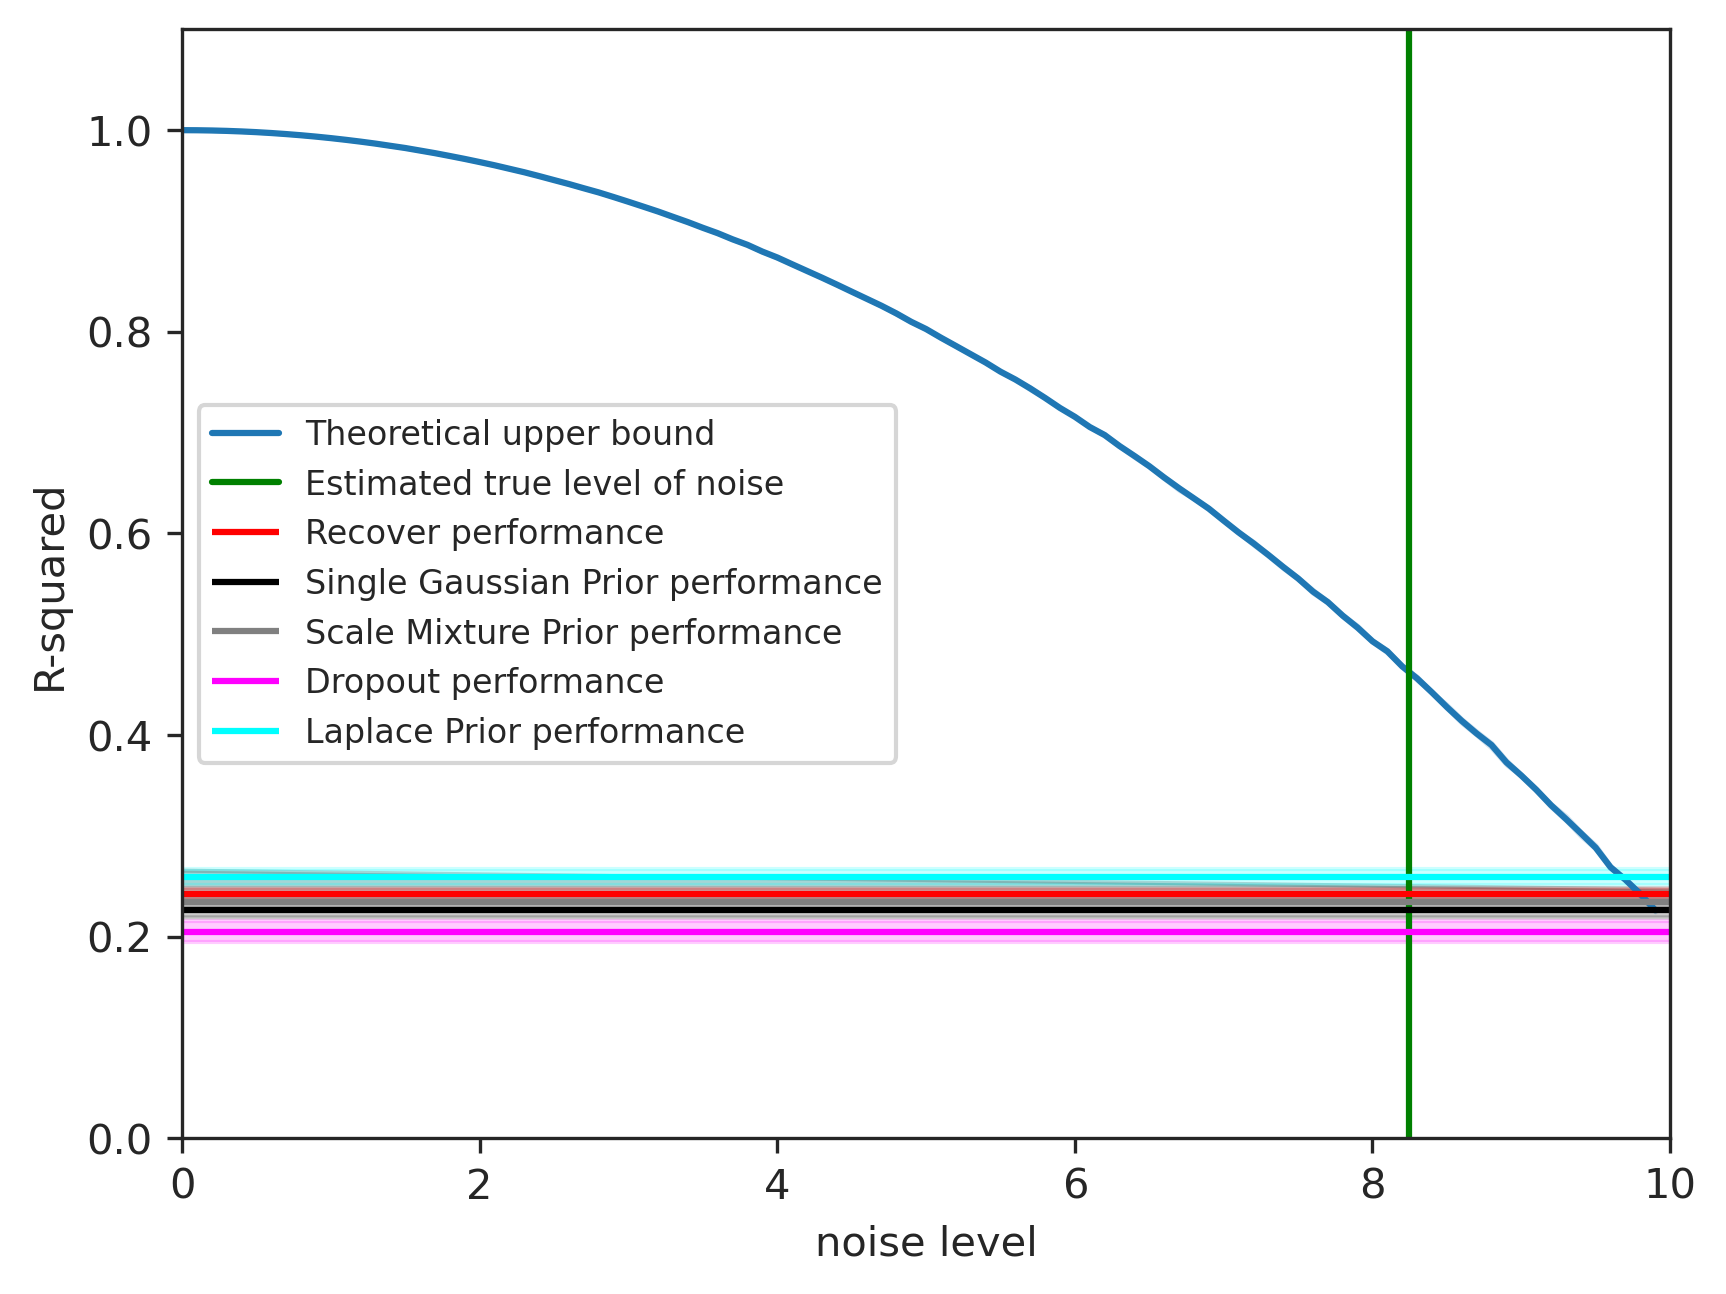

In [18]:
plt.figure(dpi=300)
sns.lineplot(data=all_r2, x='noise level', y='R-squared', label="Theoretical upper bound")

plt.axvline(x=real_bliss_sigma, color='green', label="Estimated true level of noise")

# Best Recover perf for r2 0.242 ±0.006
plt.hlines(y=0.242, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, 
           color='red', label="Recover performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.242-0.006, 0.242-0.006], y2=[0.242+0.006, 0.242+0.006], alpha=0.2, color='red')

# Best Single Gaussian for spearman corr. 0.226 ± 0.00
plt.hlines(y=0.226, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='black', label="Single Gaussian Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.226-0.007, 0.226-0.007], y2=[0.26+0.007, 0.226+0.007], alpha=0.2, color='black')

# Best Mixture Gaussian for spearman corr. 0.234 ± 0.006
plt.hlines(y=0.234, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='grey', label="Scale Mixture Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.234-0.006, 0.234-0.006], y2=[0.234+0.006, 0.234+0.006], alpha=0.2, color='grey')

# Best Dropout for spearman corr. 0.205 ± 0.01
plt.hlines(y=0.205, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='magenta', label="Dropout performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.205-0.01, 0.205-0.01], y2=[0.205+0.01, 0.205+0.01], alpha=0.2, color='magenta')

# Best Laplace for spearman corr. 0.259 ± 0.008
plt.hlines(y=0.259, xmin=real_bliss_sigma - real_bliss_sigma_std, 
           xmax=real_bliss_sigma + real_bliss_sigma_std, color='cyan', label="Laplace Prior performance")
plt.fill_between(x=[real_bliss_sigma - real_bliss_sigma_std, real_bliss_sigma + real_bliss_sigma_std], 
                 y1=[0.259-0.008, 0.259-0.008], y2=[0.259+0.008, 0.259+0.008], alpha=0.2, color='cyan')

plt.ylim(0, 1.1)
plt.xlim(0, 10)
plt.legend(fontsize = "8", loc="center left")
plt.show()

In [13]:
all_r2.groupby(['noise level']).std().mean()

R-squared    0.000673
dtype: float64

In [14]:
all_spear_corr.groupby(['noise level']).std().mean()

Spearman correlation    0.000502
dtype: float64